In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# baseline

In [ ]:
!pip install igraph

In [ ]:
%%writefile public_baseline.py
import random
import numpy as np
import igraph
import csv
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
import nltk


nltk.download('punkt') # for tokenization
nltk.download('stopwords')
stpwds = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.PorterStemmer()

with open("/gdrive/MyDrive/MLNS/training_set.txt", "r") as f:
    reader = csv.reader(f)
    testing_set  = list(reader)

testing_set = [element[0].split(" ") for element in testing_set]

###################
# random baseline #
###################

random_predictions = np.random.choice([0, 1], size=len(testing_set))
random_predictions = zip(range(len(testing_set)),random_predictions)

with open("/gdrive/MyDrive/MLNS/random_predictions.csv","wb") as pred:
    csv_out = csv.writer(pred)
    for row in random_predictions:
        print(row, type(row), list(row), csv_out)
        csv_out.writerow(row)
        
# note: Kaggle requires that you add "ID" and "category" column headers

###############################
# beating the random baseline #
###############################

# the following script gets an F1 score of approximately 0.66

# data loading and preprocessing 

# the columns of the data frame below are: 
# (1) paper unique ID (integer)
# (2) publication year (integer)
# (3) paper title (string)
# (4) authors (strings separated by ,)
# (5) name of journal (optional) (string)
# (6) abstract (string) - lowercased, free of punctuation except intra-word dashes

with open("/gdrive/MyDrive/MLNS/testing_set.txt", "r") as f:
    reader = csv.reader(f)
    training_set  = list(reader)

training_set = [element[0].split(" ") for element in training_set]

with open("/gdrive/MyDrive/MLNS/node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info  = list(reader)

IDs = [element[0] for element in node_info]

# compute TFIDF vector of each paper
corpus = [element[5] for element in node_info]
vectorizer = TfidfVectorizer(stop_words="english")
# each row is a node in the order of node_info
features_TFIDF = vectorizer.fit_transform(corpus)

## the following shows how to construct a graph with igraph
## even though in this baseline we don't use it
## look at http://igraph.org/python/doc/igraph.Graph-class.html for feature ideas

#edges = [(element[0],element[1]) for element in training_set if element[2]=="1"]

## some nodes may not be connected to any other node
## hence the need to create the nodes of the graph from node_info.csv,
## not just from the edge list

#nodes = IDs

## create empty directed graph
#g = igraph.Graph(directed=True)
 
## add vertices
#g.add_vertices(nodes)
 
## add edges
#g.add_edges(edges)

# for each training example we need to compute features
# in this baseline we will train the model on only 5% of the training set

# randomly select 5% of training set
to_keep = random.sample(range(len(training_set)), k=int(round(len(training_set)*0.05)))
training_set_reduced = [training_set[i] for i in to_keep]

# we will use three basic features:

# number of overlapping words in title
overlap_title = []

# temporal distance between the papers
temp_diff = []

# number of common authors
comm_auth = []

counter = 0
for i in range(len(training_set_reduced)):
    source = training_set_reduced[i][0]
    target = training_set_reduced[i][1]
    
    index_source = IDs.index(source)
    index_target = IDs.index(target)
    
    source_info = [element for element in node_info if element[0]==source][0]
    target_info = [element for element in node_info if element[0]==target][0]
    
	# convert to lowercase and tokenize
    source_title = source_info[2].lower().split(" ")
	# remove stopwords
    source_title = [token for token in source_title if token not in stpwds]
    source_title = [stemmer.stem(token) for token in source_title]
    
    target_title = target_info[2].lower().split(" ")
    target_title = [token for token in target_title if token not in stpwds]
    target_title = [stemmer.stem(token) for token in target_title]
    
    source_auth = source_info[3].split(",")
    target_auth = target_info[3].split(",")
    
    overlap_title.append(len(set(source_title).intersection(set(target_title))))
    temp_diff.append(int(source_info[1]) - int(target_info[1]))
    comm_auth.append(len(set(source_auth).intersection(set(target_auth))))
   
    counter += 1
    if counter % 1000 == True:
        print (counter, "training examples processsed")

# convert list of lists into array
# documents as rows, unique words as columns (i.e., example as rows, features as columns)
training_features = np.array([overlap_title, temp_diff, comm_auth]).T

# scale
training_features = preprocessing.scale(training_features)

# convert labels into integers then into column array
labels = [int(element[2]) for element in training_set_reduced]
labels = list(labels)
labels_array = np.array(labels)

# initialize basic SVM
classifier = svm.LinearSVC()

# train
classifier.fit(training_features, labels_array)

# test
# we need to compute the features for the testing set

overlap_title_test = []
temp_diff_test = []
comm_auth_test = []
   
counter = 0
for i in range(len(testing_set)):
    source = testing_set[i][0]
    target = testing_set[i][1]
    
    index_source = IDs.index(source)
    index_target = IDs.index(target)
    
    source = training_set_reduced[i][0]
    target = training_set_reduced[i][1]
    
    index_source = IDs.index(source)
    index_target = IDs.index(target)
    
    source_info = [element for element in node_info if element[0]==source][0]
    target_info = [element for element in node_info if element[0]==target][0]
    
    source_title = source_info[2].lower().split(" ")
    source_title = [token for token in source_title if token not in stpwds]
    source_title = [stemmer.stem(token) for token in source_title]
    
    target_title = target_info[2].lower().split(" ")
    target_title = [token for token in target_title if token not in stpwds]
    target_title = [stemmer.stem(token) for token in target_title]
    
    source_auth = source_info[3].split(",")
    target_auth = target_info[3].split(",")
    
    overlap_title_test.append(len(set(source_title).intersection(set(target_title))))
    temp_diff_test.append(int(source_info[1]) - int(target_info[1]))
    comm_auth_test.append(len(set(source_auth).intersection(set(target_auth))))
   
    counter += 1
    if counter % 1000 == True:
        print(counter, "testing examples processsed")
        
# convert list of lists into array
# documents as rows, unique words as columns (i.e., example as rows, features as columns)
testing_features = np.array([overlap_title_test,temp_diff_test,comm_auth_test]).T

# scale
testing_features = preprocessing.scale(testing_features)

# issue predictions
predictions_SVM = list(classifier.predict(testing_features))

# write predictions to .csv file suitable for Kaggle (just make sure to add the column names)
predictions_SVM = zip(range(len(testing_set)), predictions_SVM)

with open("improved_predictions.csv","wb") as pred1:
    csv_out = csv.writer(pred1)
    for row in predictions_SVM:
        csv_out.writerow(row)

Writing public_baseline.py


In [ ]:
!python  public_baseline.py

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
(0, 0) <class 'tuple'> [0, 0] <_csv.writer object at 0x7f96ce0789b0>
Traceback (most recent call last):
  File "public_baseline.py", line 34, in <module>
    csv_out.writerow(row)
TypeError: a bytes-like object is required, not 'str'


# using pandas

## init

In [ ]:
import pandas as pd
training_set = pd.read_csv("/gdrive/MyDrive/MLNS/training_set.txt", sep=" ", header=None, names = ["col1", "col2", "label"])
testing_set = pd.read_csv("/gdrive/MyDrive/MLNS/testing_set.txt", sep=" ", header=None, names = ["col1", "col2"])
training_set.head()

,col1,col2,label
0,9510123,9502114,1
1,9707075,9604178,1
2,9312155,9506142,0
3,9911255,302165,0
4,9701033,209076,0


In [ ]:
node_info = pd.read_csv("/gdrive/MyDrive/MLNS/node_information.csv", header=None, names =["col1", "year", "title", "author", "topic", "text"])
node_info.head()

,col1,year,title,author,topic,text
0,1001,2000,compactification geometry and duality,Paul S. Aspinwall,NaN,these are notes based on lectures given at tas...
1,1002,2000,domain walls and massive gauged supergravity p...,"M. Cvetic, H. Lu, C.N. Pope",Class.Quant.Grav.,we point out that massive gauged supergravity ...
2,1003,2000,comment on metric fluctuations in brane worlds,"Y.S. Myung, Gungwon Kang",NaN,recently ivanov and volovich hep-th 9912242 cl...
3,1004,2000,moving mirrors and thermodynamic paradoxes,Adam D. Helfer,Phys.Rev.,quantum fields responding to moving mirrors ha...
4,1005,2000,bundles of chiral blocks and boundary conditio...,"J. Fuchs, C. Schweigert",NaN,proceedings of lie iii clausthal july 1999 var...


In [ ]:
print(node_info.shape, training_set.shape, testing_set.shape, training_set.shape[0]+testing_set.shape[0])
node_info[node_info.col1 ==9510123]

(27770, 6) (615512, 3) (32648, 2) 648160


,col1,year,title,author,topic,text
16827,9510123,1995,an infinite number of potentials surrounding 2...,NaN,Phys.Lett.,we found an infinite number of potentials surr...


In [ ]:
# we will use three basic features:

# number of overlapping words in title
overlap_title = []

# temporal distance between the papers
temp_diff = []

# number of common authors
comm_auth = []

In [ ]:
df = pd.merge(training_set, node_info, on=["col1"])
df = pd.merge(df, node_info, left_on=["col2"], right_on=["col1"])
print(df.shape, df.label.unique())
df.head(2)

(615512, 14) [1 0]


,col1_x,col2,label,year_x,title_x,author_x,topic_x,text_x,col1_y,year_y,title_y,author_y,topic_y,text_y
0,9510123,9502114,1,1995,an infinite number of potentials surrounding 2...,NaN,Phys.Lett.,we found an infinite number of potentials surr...,9502114,1995,stability analysis of the dilatonic black hole...,"Won T. Kim, Julian Lee, , Young Jai Park",Phys.Lett.,we explicitly show that the net number of degr...
1,9604093,9502114,1,1996,quantisation of 2d-gravity with weyl and area-...,"J.-G. Zhou, Y.-G. Miao, J.-Q.Liang, H.J.W.Muel...",Z.Phys.,invariances the constraint structure of 2d-gra...,9502114,1995,stability analysis of the dilatonic black hole...,"Won T. Kim, Julian Lee, , Young Jai Park",Phys.Lett.,we explicitly show that the net number of degr...


## features

### PorterStemmer (tokenization)

In [ ]:
def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    return set(stemmed_tokens)

In [ ]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
porter_stemmer = PorterStemmer()

df['title_x_stem'] = df['title_x'].apply(stem_sentences)
df['title_y_stem'] = df['title_y'].apply(stem_sentences)
df['text_x_stem'] = df['text_x'].apply(stem_sentences)
df['text_y_stem'] = df['text_y'].apply(stem_sentences)
df['topic_x_stem'] = df['topic_x'].apply(stem_sentences)
df['topic_y_stem'] = df['topic_y'].apply(stem_sentences)
df['author_x_stem'] = df['author_x'].apply(stem_sentences)
df['author_y_stem'] = df['author_y'].apply(stem_sentences)

In [ ]:
df

In [ ]:
df.title_x_stem[0].intersection(df.title_x_stem[0])

{'2d', 'an', 'black', 'hole', 'infinit', 'number', 'of', 'potenti', 'surround'}

In [ ]:
df.title_x_stem[0]

{'2d', 'an', 'black', 'hole', 'infinit', 'number', 'of', 'potenti', 'surround'}

### alt

# Model

# attempt 3

In [ ]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 7.7 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [ ]:
import pandas as pd
training_set = pd.read_csv("/gdrive/MyDrive/MLNS/training_set.txt", sep=" ", header=None, names = ["col1", "col2", "label"])
testing_set = pd.read_csv("/gdrive/MyDrive/MLNS/testing_set.txt", sep=" ", header=None, names = ["col1", "col2"])
training_set.head()

,col1,col2,label
0,9510123,9502114,1
1,9707075,9604178,1
2,9312155,9506142,0
3,9911255,302165,0
4,9701033,209076,0


In [ ]:
node_info = pd.read_csv("/gdrive/MyDrive/MLNS/node_information.csv", header= None)
node_info.columns = ['id', 'pub_year', 'title', 'authors', 'journal_name', 'abstract']
node_info = node_info.set_index('id')
node_info.head(3)

,pub_year,title,authors,journal_name,abstract
id,,,,,
1001,2000,compactification geometry and duality,Paul S. Aspinwall,NaN,these are notes based on lectures given at tas...
1002,2000,domain walls and massive gauged supergravity p...,"M. Cvetic, H. Lu, C.N. Pope",Class.Quant.Grav.,we point out that massive gauged supergravity ...
1003,2000,comment on metric fluctuations in brane worlds,"Y.S. Myung, Gungwon Kang",NaN,recently ivanov and volovich hep-th 9912242 cl...


In [ ]:
training = pd.read_csv('/gdrive/MyDrive/MLNS/training_set.txt', sep = ' ', header = None)
training.head(3)

,0,1,2
0,9510123,9502114,1
1,9707075,9604178,1
2,9312155,9506142,0


In [ ]:
import networkx as nx

IDs = [node_id for node_id in node_info.index]

training_list = training.values.tolist() # training dataframe convertion for easy edges list comprehension below
edges = [(node_pair[0], node_pair[1]) for node_pair in training_list if node_pair[2] == 1]

G = nx.DiGraph()
G.add_nodes_from(IDs)
G.add_edges_from(edges)

print("Number of nodes : " + str(G.number_of_nodes()))
print("Number of edges : " + str(G.number_of_edges()))

Number of nodes : 27770
Number of edges : 335130


In [ ]:
import random

training_reduced = training.sample(frac=0.05) # We keep 5%
training_reduced.columns = ['source', 'target', 'Y']

training_reduced.head(3)

,source,target,Y
149359,9150,2146,0
323467,9502053,9407089,1
231089,208161,5108,0


In [ ]:
# Degree Centrality features
out_degree_centrality = nx.out_degree_centrality(G)
in_degree_centrality = nx.in_degree_centrality(G)
training_reduced['source_out_centrality'] = training_reduced.apply(lambda row: out_degree_centrality[row.source],axis=1)
training_reduced['target_in_centrality'] = training_reduced.apply(lambda row: in_degree_centrality[row.target],axis=1)

# Page rank
page_rank = nx.pagerank_scipy(G)
training_reduced['target_pagerank'] = training_reduced.apply(lambda row: page_rank[row.target],axis=1)

# Preferential Attachment
# For a directed graph, is equal to K_out_source * K_in_target with K the number of neighbors. Which is equivalent to multiply the available centralities.
training_reduced['preferencial_attachment'] = training_reduced.apply(lambda row: row.source_out_centrality * row.target_in_centrality,axis=1)

# HITS algorithm
hub_score, authority_score = nx.hits(G)
training_reduced['source_hub_score'] = training_reduced.apply(lambda row: hub_score[row.source],axis=1)
training_reduced['target_authority_score'] = training_reduced.apply(lambda row: authority_score[row.target],axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: networkx.pagerank_scipy is deprecated and will be removed in NetworkX 3.0, use networkx.pagerank instead.
  


In [ ]:
training_reduced.head(3)

,source,target,Y,source_out_centrality,target_in_centrality,target_pagerank,preferencial_attachment,source_hub_score,target_authority_score
149359,9150,2146,0,0.000396,0.000396,0.000017,1.569152e-07,2.337360e-05,1.951651e-05
323467,9502053,9407089,1,0.000324,0.000648,0.000054,2.100848e-07,5.806559e-08,8.654609e-08
231089,208161,5108,0,0.000828,0.000216,0.000017,1.789611e-07,4.951652e-05,1.450209e-05


In [ ]:
# Publication year
training_reduced['pub_year_difference'] = training_reduced.apply(lambda row: node_info.pub_year[row.source] - node_info.pub_year[row.target] ,axis=1)
training_reduced['pub_year_difference']=training_reduced['pub_year_difference'].where(training_reduced['pub_year_difference'] < 0, -1)

# Title
training_reduced['title_similarity'] = training_reduced.apply(lambda row: nlp(node_info.title[row.source]).similarity(nlp(node_info.title[row.target])) ,axis=1)

# Abstract`
training_reduced['abstract_similarity'] = training_reduced.apply(lambda row: nlp(node_info.abstract[row.source]).similarity(nlp(node_info.abstract[row.target])) ,axis=1)

# Authors
node_info['authors'] = node_info['authors'].fillna(value='')
training_reduced['common_authors'] = training_reduced.apply(lambda row: len(set(node_info.authors[row.source].split(",")).intersection(set(node_info.authors[row.target].split(",")))) ,axis=1)
training_reduced.head(3)

/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__mai

,source,target,Y,source_out_centrality,target_in_centrality,target_pagerank,preferencial_attachment,source_hub_score,target_authority_score,pub_year_difference,title_similarity,abstract_similarity,common_authors
149359,9150,2146,0,0.000396,0.000396,0.000017,1.569152e-07,2.337360e-05,1.951651e-05,-1,0.285748,0.911505,0
323467,9502053,9407089,1,0.000324,0.000648,0.000054,2.100848e-07,5.806559e-08,8.654609e-08,-1,0.706097,0.951139,0
231089,208161,5108,0,0.000828,0.000216,0.000017,1.789611e-07,4.951652e-05,1.450209e-05,-1,0.676267,0.916618,0


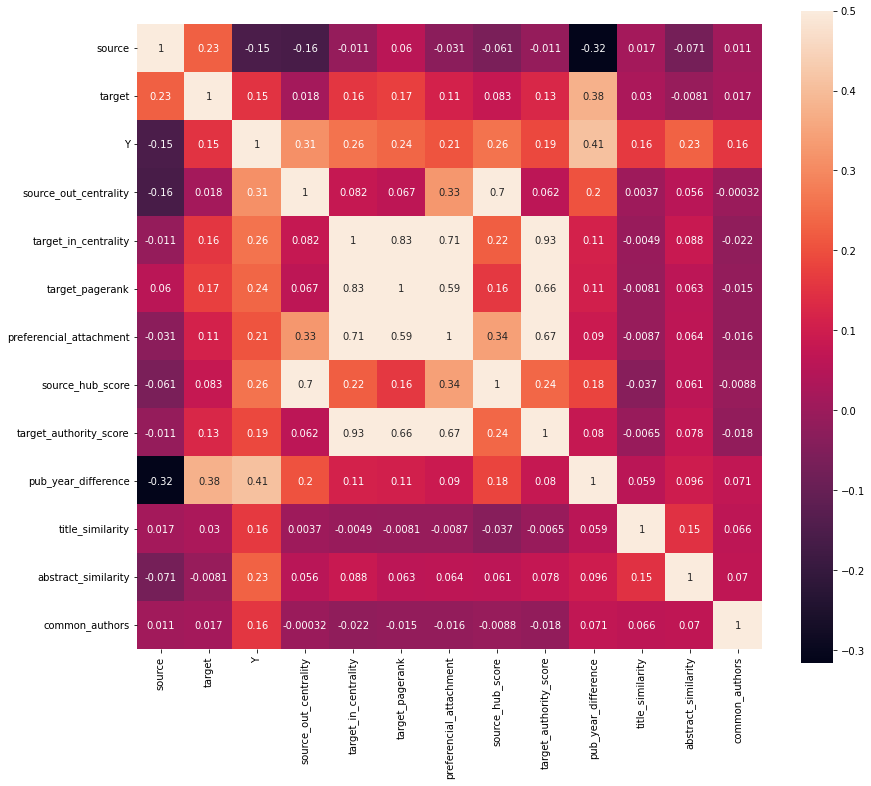

In [ ]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,12))
sns.heatmap(training_reduced.corr(),
            vmax=0.5,
            square=True,
            annot=True)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(training_reduced.drop(['source', 'target', 'Y'], axis= 1), training_reduced.Y, test_size=0.2)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF_classifer =  RandomForestClassifier(n_estimators= 1000)
RF_classifer.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [ ]:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, 
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(n_estimators=1000, n_jobs=1)

In [ ]:
RF_classifer.score(X_test, y_test)

0.9039961013645225

In [ ]:
testing = pd.read_csv('/gdrive/MyDrive/MLNS/testing_set.txt', sep = ' ', header = None)
testing.head(3)

,0,1
0,9807076,9807139
1,109162,1182
2,9702187,9510135


In [ ]:
import networkx as nx

IDs_test = [node_id for node_id in node_info.index]

testing_list = testing.values.tolist() # testing dataframe convertion for easy edges list comprehension below
edges_test = [(node_pair[0], node_pair[1]) for node_pair in testing_list]

G_test = nx.DiGraph()
G_test.add_nodes_from(IDs_test)
G_test.add_edges_from(edges_test)

print("Number of nodes : " + str(G_test.number_of_nodes()))
print("Number of edges : " + str(G_test.number_of_edges()))

Number of nodes : 27770
Number of edges : 32648


In [ ]:
testing.columns = ['source', 'target']

# Degree Centrality features
testing['source_out_centrality'] = testing.apply(lambda row: out_degree_centrality[row.source],axis=1)
testing['target_in_centrality'] = testing.apply(lambda row: in_degree_centrality[row.target],axis=1)
# Page rank
testing['target_pagerank'] = testing.apply(lambda row: page_rank[row.target],axis=1)
# Preferential Attachment
# For a directed graph, is equal to K_out_source * K_in_target with K the number of neighbors. Which is equivalent to multiply the available centralities.
testing['preferencial_attachment'] = testing.apply(lambda row: row.source_out_centrality * row.target_in_centrality,axis=1)
# HITS algorithm
testing['source_hub_score'] = testing.apply(lambda row: hub_score[row.source],axis=1)
testing['target_authority_score'] = testing.apply(lambda row: authority_score[row.target],axis=1)
# Publication year
testing['pub_year_difference'] = testing.apply(lambda row: node_info.pub_year[row.source] - node_info.pub_year[row.target] ,axis=1)
testing['pub_year_difference']=testing['pub_year_difference'].where(testing['pub_year_difference'] < 0, -1)
# Title
testing['title_similarity'] = testing.apply(lambda row: nlp(node_info.title[row.source]).similarity(nlp(node_info.title[row.target])) ,axis=1)
# Abstractx6
testing['abstract_similarity'] = testing.apply(lambda row: nlp(node_info.abstract[row.source]).similarity(nlp(node_info.abstract[row.target])) ,axis=1)
# Authors
testing['common_authors'] = testing.apply(lambda row: len(set(node_info.authors[row.source].split(",")).intersection(set(node_info.authors[row.target].split(",")))) ,axis=1)

/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__mai

In [ ]:
predictions = RF_classifer.predict(testing.drop(['source', 'target'], axis = 1))
predictions_df = pd.DataFrame(predictions)
predictions_df.to_csv('/gdrive/MyDrive/MLNS/save/predictions.csv')

In [ ]:
predictions_df.head(2)

,0
0,0
1,1


In [ ]:
p2 = predictions_df
p2.head()

,0,category
id,,
0,0,0
1,1,1
2,1,1
3,1,1
4,1,1


In [ ]:
p2.index.names = ["id"]
p2.rename(columns={"0": "category"})
p2["category"] = p2[0]
p2 = p2.drop([0], axis=1)
p2.head()

,category
id,
0,0
1,1
2,1
3,1
4,1


In [ ]:

p2.to_csv('/gdrive/MyDrive/MLNS/save/predictions_RF_March7.csv')

# attempt 4

In [ ]:
%%time
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
CPU times: user 909 ms, sys: 261 ms, total: 1.17 s
Wall time: 1.7 s


In [ ]:
import csv
import time
import numpy as np
import networkx as nx
import pandas as pd
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [ ]:


 ## Loads the node information
with open("/gdrive/MyDrive/MLNS/node_information.csv", "r") as f:
    file = csv.reader(f)
    node = list(file)

ID = [int(i[0]) for i in node]
year=[int(i[1]) for i in node]
title=[i[2] for i in node]
authors=[i[3] for i in node]
name_journal=[i[4] for i in node]
abstract=[i[5] for i in node]

In [ ]:

"""
    Construction of the graph
"""
with open("/gdrive/MyDrive/MLNS/training_set.txt", "r") as f:
    file =csv.reader(f, delimiter='\t')
    set_file=list(file)
set= np.array([values[0].split(" ") for values in set_file]).astype(int)



In [ ]:

## Creates the oriented graph
diG=nx.DiGraph()
#adds the list of papers' IDs
diG.add_nodes_from(ID)
#adds the corresponding links between the paper (training set), links when link_test==1
for ID_source_train,ID_sink_train,link_train in set:
    if link_train==1:
        diG.add_edge(ID_source_train,ID_sink_train)

  ## Checks the number of edges and creates the non-oriented graph G
G = nx.Graph(diG)
print(diG.nodes)

[1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1100, 1101, 1102, 1103, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 117

In [ ]:


"""
    Construction of the features
"""
    ## Useful graph-based features computed at once
page_rank = nx.pagerank_scipy(G)
hub_score, authority_score = nx.hits(G)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: networkx.pagerank_scipy is deprecated and will be removed in NetworkX 3.0, use networkx.pagerank instead.
  import sys


In [ ]:

    ##One_hot vectors on abstract (usefull for co_occurence computations in features construction function)
one_hot = CountVectorizer(stop_words="english")
one_hot_matrix = one_hot.fit_transform(abstract)#.todense()



In [ ]:
    ## One_hot vectors on authors (usefull for co_occurence computations in features construction function)
onehot_authors= CountVectorizer()
onehot_authors_matrix=onehot_authors.fit_transform(authors)

In [ ]:

    ##One_hot vectors on titles (usefull for co_occurence computations in features construction function)
onehot_titles= CountVectorizer()
onehot_titles_matrix=onehot_titles.fit_transform(title)


In [ ]:

    ##TF-IDF cosine similarity
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(abstract)

    ## 23-gram co-occurence. VERY VERY COMPUTATIONALLY DEMANDING
#one_got_23gram = CountVectorizer(binary = True, stop_words = "english", ngram_range = (2,3))
#one_got_23gram_matrix = one_got_23gram.fit_transform(abstract)



In [ ]:

def features(paper1,paper2):
    """
        Outputs the array of the features to input in the prediction models
    """
    idx_paper1,idx_paper2=ID.index(paper1),ID.index(paper2)

    ## Features from contextual information of the nodes
    co_occurence_abstract=np.dot(one_hot_matrix[idx_paper1],one_hot_matrix[idx_paper2].T).toarray()[0][0]
    same_authors=np.dot(onehot_authors_matrix[idx_paper1],onehot_authors_matrix[idx_paper2].T).toarray()[0][0]
    co_occurence_title=np.dot(onehot_titles_matrix[idx_paper1],onehot_titles_matrix[idx_paper2].T).toarray()[0][0]

    #tfidf cosine similarity
    tf1 = tfidf_matrix[idx_paper1]# in case tfidf mat is so large that it's stored as a sparse matrix
    tf2 = tfidf_matrix[idx_paper2]# in case tfidf mat is so largs that it's stared as a sparse matrix
    tfidf_sim = cosine_similarity(tf1, tf2)[0][0]

    #VERY COMPUTATIONALLY EXPENSIVE
    #twothree_gram = np.sum(one_got_23gram_matrix[idx_paper1].toarray() * one_got_23gram_matrix[idx_paper2].toarray())

    same_journal = int(name_journal[idx_paper1] == name_journal[idx_paper2])

    ## Irrelevant tested feature
    # try:
    #     distance=1/len(nx.shortest_path(G, paper1, paper2))
    # except:
    #     distance=0

    years_diff=int(year[idx_paper1])-int(year[idx_paper2])

    ## Features over the graph
    jaccard = nx.jaccard_coefficient(G, [(paper1, paper2)])
    for u, v, p in jaccard:
        jaccard_coef= p
    adamic_adar=nx.adamic_adar_index(G, [(paper1, paper2)])
    for u, v, p in adamic_adar:
        adamic_adar_coef= p
    pref_attachement = nx.preferential_attachment(G, [(paper1, paper2)])
    for u, v, p in pref_attachement:
        pref_attachement_coef= p
    common_neig=len(sorted(nx.common_neighbors(G, paper1, paper2)))

    ## features over the directed graph
    triad_features = [0.0]*8
    for w in sorted(nx.common_neighbors(G, paper1, paper2)):
        if G.has_edge(paper1, w) and G.has_edge(w, paper2):
            triad_features[0]+=1
        if G.has_edge(paper1, w) and G.has_edge(paper2, w):
            triad_features[1]+=1
        if G.has_edge(w, paper1) and G.has_edge(w, paper2):
            triad_features[2] += 1
        if G.has_edge(w, paper1) and G.has_edge(paper2, w):
            triad_features[3] += 1
    for i in range(4, 8):
        if triad_features[i-4]!=0:
            triad_features[i] = triad_features[i-4]/common_neig

    #VERY COMPUTATIONALLY EXPENSIVE
    ## Katz similarity (Very expansive) -> not used a final feature
    # katz = 0
    # beta = 0.005
    # path_length = []
    # for path in nx.all_simple_paths(G, source=source, target=sink, cutoff=3):
    #     path_length.append(len(path))
    # a = np.array(path_length)
    # unique, counts = np.unique(a, return_counts=True)
    # dict_katz = dict(zip(unique, counts))
    # for length in dict_katz:
    #     katz += dict_katz[length] * beta ** length * length

    ## Sum up of all features
    degree_features = [diG.in_degree(paper1), diG.out_degree(paper1), diG.in_degree(paper2), diG.out_degree(paper2)]
    heuristic_graph_features = [jaccard_coef, adamic_adar_coef, pref_attachement_coef, common_neig] # one ccan add if computed katz
    node_info_features = [co_occurence_abstract, same_authors, co_occurence_title, years_diff, same_journal, tfidf_sim] # + [twothree_gram] if computed #

    heuristic_graph_features += [page_rank[paper2]] + [hub_score[paper1]]+ [authority_score[paper2]]

    return node_info_features + heuristic_graph_features + degree_features + triad_features  ## 25 features in total


In [ ]:
start = time.time()
"""
    Build the data sets based on given files
"""
## To save the X_train,y_train matrices. Expansive to compute
saved = False

train_features= []
if saved:
    train_features= np.load("/gdrive/MyDrive/MLNS/save/train_features_full.npy")
y_train=[]
print("Features construction for Learning...")
step=0
for source,sink,link in set:
    step+=1
    if step%1000==0:    print("Step:",step,"/",len(set)) 
    if not saved:
        train_features.append(features(source,sink))
    y_train.append(link)
train_features=np.array(train_features)
SS = StandardScaler().fit(train_features)
train_features = SS.transform(train_features)
y_train=np.array(y_train)
if not saved:
    np.save("/gdrive/MyDrive/MLNS/save/train_features.npy", train_features)



end = time.time()
print(end - start)

Features construction for Learning...
Step: 1000 / 615512
Step: 2000 / 615512
Step: 3000 / 615512
Step: 4000 / 615512
Step: 5000 / 615512
Step: 6000 / 615512
Step: 7000 / 615512
Step: 8000 / 615512
Step: 9000 / 615512
Step: 10000 / 615512
Step: 11000 / 615512
Step: 12000 / 615512
Step: 13000 / 615512
Step: 14000 / 615512
Step: 15000 / 615512
Step: 16000 / 615512
Step: 17000 / 615512
Step: 18000 / 615512
Step: 19000 / 615512
Step: 20000 / 615512
Step: 21000 / 615512
Step: 22000 / 615512
Step: 23000 / 615512
Step: 24000 / 615512
Step: 25000 / 615512
Step: 26000 / 615512
Step: 27000 / 615512
Step: 28000 / 615512
Step: 29000 / 615512
Step: 30000 / 615512
Step: 31000 / 615512
Step: 32000 / 615512
Step: 33000 / 615512
Step: 34000 / 615512
Step: 35000 / 615512
Step: 36000 / 615512
Step: 37000 / 615512
Step: 38000 / 615512
Step: 39000 / 615512
Step: 40000 / 615512
Step: 41000 / 615512
Step: 42000 / 615512
Step: 43000 / 615512
Step: 44000 / 615512
Step: 45000 / 615512
Step: 46000 / 615512
Step:

In [ ]:


### Load the set to work on for kaggle prediction
with open("/gdrive/MyDrive/MLNS/testing_set.txt", "r") as f:
    file =csv.reader(f, delimiter='\t')
    set_file=list(file)
set_test= np.array([values[0].split(" ") for values in set_file]).astype(int)


In [ ]:
start = time.time()
test_features=[]
if saved:
    test_features=np.load("/gdrive/MyDrive/MLNS/save/test_features_full.npy")
y_test=[]
print("Features construction for Testing...")
step=0
for source,sink in set_test: ##set_test: ##
    step+=1
    if step%1000==0:    print("Step:",step,"/",len(set_test))
    if not saved:
        test_features.append(features(source,sink))
test_features=np.array(test_features)
SS = StandardScaler().fit(test_features)
test_features = SS.transform(test_features)
if not saved:
    np.save("/gdrive/MyDrive/MLNS/save/test_features.npy", test_features)


end = time.time()
print(end - start)

Features construction for Testing...
Step: 1000 / 32648
Step: 2000 / 32648
Step: 3000 / 32648
Step: 4000 / 32648
Step: 5000 / 32648
Step: 6000 / 32648
Step: 7000 / 32648
Step: 8000 / 32648
Step: 9000 / 32648
Step: 10000 / 32648
Step: 11000 / 32648
Step: 12000 / 32648
Step: 13000 / 32648
Step: 14000 / 32648
Step: 15000 / 32648
Step: 16000 / 32648
Step: 17000 / 32648
Step: 18000 / 32648
Step: 19000 / 32648
Step: 20000 / 32648
Step: 21000 / 32648
Step: 22000 / 32648
Step: 23000 / 32648
Step: 24000 / 32648
Step: 25000 / 32648
Step: 26000 / 32648
Step: 27000 / 32648
Step: 28000 / 32648
Step: 29000 / 32648
Step: 30000 / 32648
Step: 31000 / 32648
Step: 32000 / 32648
231.45714235305786


136.71296072006226


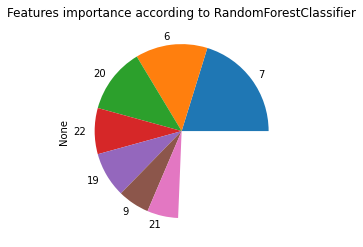

In [ ]:
start = time.time()
"""
    Data visualization
"""

    ## Features importance plot
model =RandomForestClassifier(n_estimators=100, max_depth=9,
                             random_state=0)
model.fit(train_features, y_train)
(pd.Series(model.feature_importances_)
.nlargest(7)
.plot(kind='pie',title="Features importance according to RandomForestClassifier"))


end = time.time()
print(end - start)

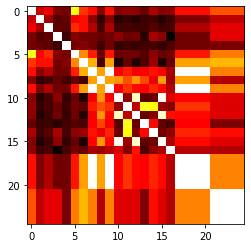

In [ ]:

    ## Correlation heat map
plt.imshow(np.corrcoef(train_features.T), cmap='hot', interpolation='nearest')
plt.show()


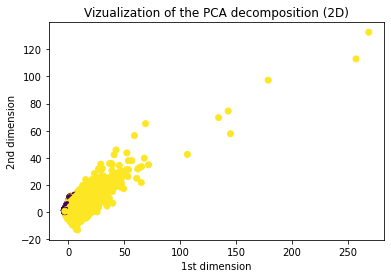

17.637155294418335


In [ ]:
start = time.time()
    ## PCA decomposition
pca = PCA(n_components=2)
X = pca.fit_transform(train_features)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X[:,0], X[:,1], c=y_train)
ax.set_xlabel('1st dimension')
ax.set_ylabel('2nd dimension')
ax.set_title("Vizualization of the PCA decomposition (2D)")
plt.show()
    ##Vizualize selected features on initial data
# feat = (i,j) #select the features to vizualize
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.scatter(train_features[:,feat[0]], train_features[:,feat[1]], c=y_train, alpha=0.8)
# ax.set_xlabel(f'Dimension {feat[0]}')
# ax.set_ylabel(f'Dimension {feat[1]}')
# ax.set_title("Vizualization of the features")
# plt.show()

end = time.time()
print(end - start)

In [ ]:
start = time.time()
    ## Another way to see least useful features (but they still change positively the prediictions quality)
print(train_features[0])
X_new = SelectKBest(f_classif, k=20).fit_transform(train_features, y_train)
print(X_new[0])

end = time.time()
print(end - start)

[-0.3842182  -0.24722207  1.62920738 -0.32844506  2.2533065  -0.10692125
  0.00435842 -0.3647014  -0.22321281 -0.46980831 -0.31151936 -0.48738495
 -0.36331336 -0.26165676 -0.62777252 -0.29766941 -0.48113969 -0.46980831
 -0.46980831 -0.46980831 -0.46980831  0.93440447  0.93440447  0.93440447
  0.93440447]
[-0.3842182   1.62920738 -0.32844506 -0.10692125  0.00435842 -0.3647014
 -0.46980831 -0.31151936 -0.48738495 -0.36331336 -0.62777252 -0.29766941
 -0.46980831 -0.46980831 -0.46980831 -0.46980831  0.93440447  0.93440447
  0.93440447  0.93440447]
0.32871532440185547


In [ ]:


"""
    Model construction + prediction
"""
    ## MLP (with parameters corresponding to one of 2 best kaggle scores)
test_features = preprocessing.scale(test_features)
train_features = preprocessing.scale(train_features)



In [ ]:
start = time.time()
clf = MLPClassifier(solver='adam', alpha=1.74e-4,activation="relu",
            hidden_layer_sizes=(65,18), tol=5e-5, max_iter=250, verbose=1)
clf = clf.fit(train_features, y_train)
pred = list(clf.predict(test_features))

end = time.time()
print(end - start)

Iteration 1, loss = 0.09524369
Iteration 2, loss = 0.08500428
Iteration 3, loss = 0.08320841
Iteration 4, loss = 0.08211023
Iteration 5, loss = 0.08132071
Iteration 6, loss = 0.08069849
Iteration 7, loss = 0.08021842
Iteration 8, loss = 0.07979442
Iteration 9, loss = 0.07950454
Iteration 10, loss = 0.07924112
Iteration 11, loss = 0.07891563
Iteration 12, loss = 0.07867318
Iteration 13, loss = 0.07845845
Iteration 14, loss = 0.07842772
Iteration 15, loss = 0.07813853
Iteration 16, loss = 0.07780311
Iteration 17, loss = 0.07771644
Iteration 18, loss = 0.07759306
Iteration 19, loss = 0.07738267
Iteration 20, loss = 0.07738802
Iteration 21, loss = 0.07706868
Iteration 22, loss = 0.07680690
Iteration 23, loss = 0.07686945
Iteration 24, loss = 0.07669705
Iteration 25, loss = 0.07664140
Iteration 26, loss = 0.07650935
Iteration 27, loss = 0.07635477
Iteration 28, loss = 0.07635076
Iteration 29, loss = 0.07627916
Iteration 30, loss = 0.07615075
Iteration 31, loss = 0.07611082
Iteration 32, los

In [ ]:

    ## Stores the predictions in the kaggle format
predictions= zip(range(len(set_test)), pred)


NameError: ignored

In [ ]:

    ## write predictions to .csv file suitable for Kaggle
with open("/gdrive/MyDrive/MLNS/save/predictions.csv","w",newline="") as pred1:
    fieldnames = ['id', 'category']
    csv_out = csv.writer(pred1)
    csv_out.writerow(fieldnames)
    for row in predictions:
        csv_out.writerow(row)

In [ ]:

"""
    Other relevant models (with tunned hyper-parameters)
"""

# # XGBoost classifier
# import xgboost as xgb
# clf = xgb.XGBClassifier(silent=True,
#                               scale_pos_weight=1,
#                               learning_rate=0.0001,
#                               colsample_bytree=0.35,
#                               subsample=0.8,
#                               objective='binary:logistic',
#                               n_estimators=100,
#                               max_depth=9,
#                               min_child_weight=2,
#                               gamma=3000,
#                               reg_alpha=3,
#                               nthread=8)
# clf = clf.fit(train_features, y_train)
# pred = list(clf.predict(test_features))
# predictions= zip(range(len(set_test)), pred)

# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.tree import DecisionTreeClassifier
# clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=12), n_estimators=300, algorithm='SAMME.R')
# clf = clf.fit(train_features, y_train)
# pred = list(clf.predict(test_features))
# predictions= zip(range(len(set_test)), pred)